## Procesamiento Datos Pandas

Complete el código faltante según corresponda a manera de lograr automatizar el flujo. Finalmente adjunte una imagen del envio de correo correspondiente.



El archivo candidates.csv contiene 50k filas de datos sobre candidatos. Los campos que estamos usando son:
- First Name
- Last Name
- Email
- Country
- Application Date
- Yoe (years of experience)
- Seniority
- Technology
- Code Challenge Score
- Technical Interview


## 1. Almaceno sobre DB

In [ ]:
# lea el articulo:
# https://medium.com/analytics-vidhya/inserting-an-image-in-an-excel-file-using-pandas-and-sql-e88826680b05


In [ ]:
!pip install xlsxwriter

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

import pandas as pd
import xlsxwriter
import sqlite3
import os

In [10]:
DB = 'candidates.db'
TABLE_NAME = 'candidate'

In [11]:
def almacenar_pandas_to_sql(df: pd.DataFrame, database_name:str, table_name:str)->None:
  """Procesamiento datos candidatos para almacenarlos sobre db """

  # rename columns
  column_rename = {c: c.replace(' ', '') for c in df.columns}
  df.rename(column_rename,axis='columns', inplace=True)

  # almaceno sobre db
  conn = sqlite3.connect(database_name)
  df.to_sql(table_name, conn, if_exists='replace', index=False)
  conn.close()

  #
  sql_table_schema = f'{database_name}.{table_name}'
  cantidad_registros = df.shape[0]
  print(f'Se almacenaron {cantidad_registros} sobre tabla sql {sql_table_schema}')

In [12]:
# read csv
path = './src/candidates.csv'
df = pd.read_csv(path,sep=';')
df.shape

(50000, 10)

In [13]:
df.head(2)

,First Name,Last Name,Email,Application Date,Country,YOE,Seniority,Technology,Code Challenge Score,Technical Interview Score
0,Bernadette,Langworth,leonard91@yahoo.com,2021-02-26,Norway,2,Intern,Data Engineer,3,3
1,Camryn,Reynolds,zelda56@hotmail.com,2021-09-09,Panama,10,Intern,Data Engineer,2,10


In [14]:
almacenar_pandas_to_sql(df, DB , TABLE_NAME)

Se almacenaron 50000 sobre tabla sql candidates.db.candidate


## 2. Procesamiento Datos

Generar un reporte por separado para los paises ( 'United States of America', 'Brazil','Colombia','Ecuador') donde se deberá seleccionar a los candidatos cuyo CodeChallengeScore y TechnicalInterviewScore sea mayor igual a 7. Se deberá crear gráficos integrados sobre cada reporte y además almacenar los datos en un excel con el nombre de cada pais.

In [15]:
# 1. Lectura de datos
with sqlite3.connect(DB) as conn:
  df = pd.read_sql_query(f'select * from {TABLE_NAME}', conn)

In [16]:
df.head(2)

,FirstName,LastName,Email,ApplicationDate,Country,YOE,Seniority,Technology,CodeChallengeScore,TechnicalInterviewScore
0,Bernadette,Langworth,leonard91@yahoo.com,2021-02-26,Norway,2,Intern,Data Engineer,3,3
1,Camryn,Reynolds,zelda56@hotmail.com,2021-09-09,Panama,10,Intern,Data Engineer,2,10


In [18]:
# 2. Filtrado de datos
# Se debe filtrar por los paises 'United States of America', 'Brazil','Colombia','Ecuador'
# COmo condicion debe ser CodeChallengeScore >=7 y TechnicalInterviewScore>=7

listado_paises="'United States of America', 'Brazil', 'Colombia', 'Ecuador'"
with sqlite3.connect(DB) as conn:
    cur = conn.cursor()
    # Write your SQL query
    query = f'''SELECT * FROM {TABLE_NAME}
    WHERE Country IN ({listado_paises})
    AND "Code Challenge Score" >= 7
    AND "Technical Interview Score" >= 7'''

    filterDf = pd.read_sql_query(query, conn)
    conn.close()

# cree filterDf

filterDf.shape

(821, 10)

In [19]:
filterDf.head(2)

,FirstName,LastName,Email,ApplicationDate,Country,YOE,Seniority,Technology,CodeChallengeScore,TechnicalInterviewScore
0,Darian,Kris,jack62@gmail.com,2021-01-01,United States of America,4,Mid-Level,Salesforce,9,4
1,Tabitha,Simonis,ella.mcclure57@hotmail.com,2021-07-21,Ecuador,15,Senior,Development - Backend,0,1


<Axes: ylabel='Technology'>

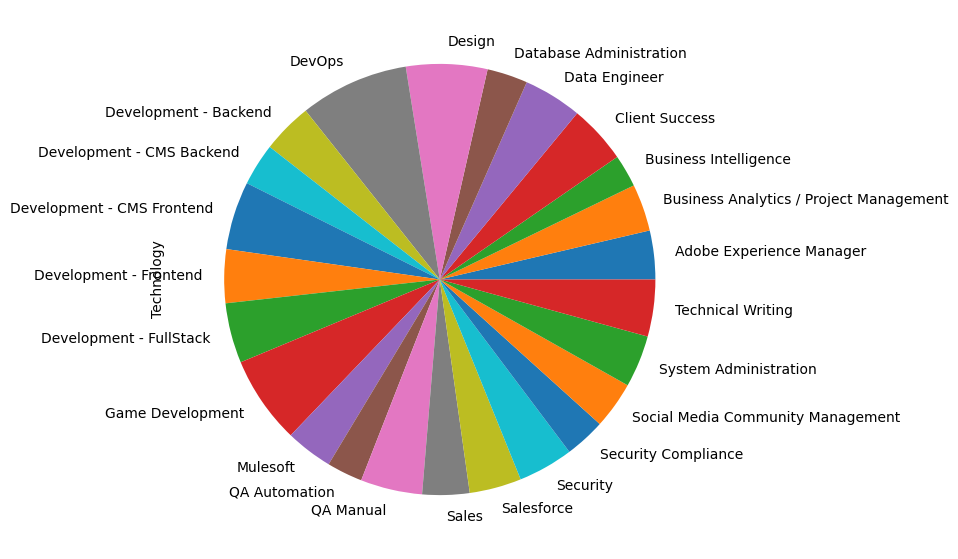

In [20]:
# - Hires by technology (pie chart)
tec = filterDf.groupby('Technology')['Technology'].count()
tec.plot.pie(figsize=(11, 7))


<Axes: xlabel='Seniority'>

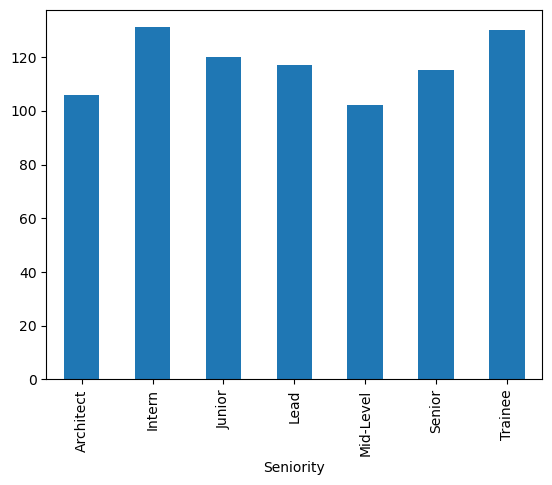

In [21]:
# - Hires by seniority (bar chart)
senority_group = filterDf.groupby('Seniority')['Seniority'].count()
senority_group.plot.bar()

### Realizo reporte automatizado

In [22]:
def genero_grafico_circular(df:pd.DataFrame, country:str)->None:
  """Funcion que se encarga de crear el gráfico en pie"""
  tec = df.groupby('Technology')['Technology'].count()
  tec.plot.pie(figsize=(11, 7))

  plt.savefig(f"./reportes/images/{country}/pie_chart.png",dpi=300, bbox_inches='tight')
  plt.close()
  print('Se genero gráfico circular ...')

In [23]:
def genero_grafico_barras(df:pd.DataFrame, country:str)->None:
  """Funcion que se encarga de crear el gráfico de barras"""

  senority_group = df.groupby('Seniority')['Seniority'].count()
  senority_group.plot.bar()

  plt.savefig(f"./reportes/images/{country}/bar_chart.png",dpi=300, bbox_inches='tight')
  plt.close()
  print('Se genero gráfico barras ...')

Se genero gráfico circular ...


IndexError: index 0 is out of bounds for axis 0 with size 0

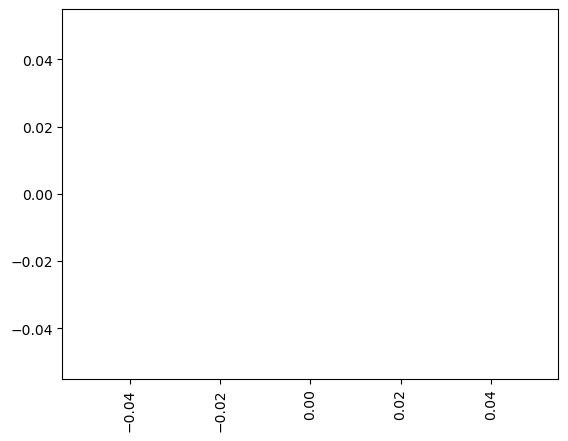

In [24]:
# genero carpetas necesarias
if not os.path.isdir('./reportes'):
  os.mkdir('reportes')
  os.mkdir('./reportes/images')

#
for country in listado_paises:
  # creo subcarpetas
  if not os.path.isdir(f'./reportes/images/{country}'):
    os.mkdir(f'./reportes/images/{country}')

  # filtro df
  countryDf = filterDf[filterDf['Country']==country]

  # genero gráficos
  genero_grafico_circular(countryDf, country)
  genero_grafico_barras(countryDf, country)

  #Genero reporte Excel por pais
  with pd.ExcelWriter(f"./reportes/{country}.xlsx", engine= "xlsxwriter") as excelBook:

    sheet_name = f"Report-{country}"
    countryDf.to_excel(excelBook, index=False, sheet_name= sheet_name)

    # posiciono sobre hoja de excel
    excel_sheet = excelBook.sheets[sheet_name]

    # almaceno imagen
    image_pie_path = f"./reportes/images/{country}/pie_chart.png"
    image_bar_path = f"./reportes/images/{country}/bar_chart.png"

    excel_sheet.insert_image(1, countryDf.shape[1]+2, image_pie_path) # 1 y df.shape +2 -> establecen posicion de imagen en libro
    excel_sheet.insert_image(countryDf.shape[0]+2, countryDf.shape[1]+2, image_bar_path)

    # Guardo cambios sobre excel
    #excelBook.close()

    print(f'Se generó reporte para el país {country}')
    pass
  print('Se finalizó  la generacion de reportes')

## 3. Envio Correo

In [25]:
def func_sender_email(**args):
  return NotImplementedError

In [26]:
# me posiciono sobre carpeta
os.chdir('reportes')

func_sender_email(sender_email='ejemplo@gmail.com',
                sender_password='tupass',
                receiver_email='destinatario@gmail.com',
                subject='Reporte Brazil',
                message='Reporte excel Brazil',
                archivo_adjunto='Brazil.xlsx')

NotImplementedError